In [1]:
# Access to Drive
# Modules
# Data import
# DataFrames

## Gives access to the Drive
from google.colab import drive
drive.mount('/content/drive')

## Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import sys, os
from pathlib import Path
import shutil
import glob
import itertools

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TerminateOnNaN, EarlyStopping

from tensorflow.keras.utils import Sequence
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

sys.path.append('/content/drive/MyDrive/Leukopy')
import leukopy_lib as leuko
from importlib import reload

reload(leuko)

## GPU status verification
tf.test.gpu_device_name()

## GPU type verification
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mounted at /content/drive
Wed Sep 29 11:41:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    33W / 250W |    345MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                              

In [2]:
########################################################################### DATAFRAME

## Need to copy all the files on the local computer
!cp -r "/content/drive/MyDrive/Leukopy/data/main_dataset.zip" .
!unzip main_dataset.zip

## Create the original dataframes
path = Path('/content/main_dataset/')

df_train = leuko.generate_images_df(path/'training_set')
df_test = leuko.generate_images_df(path/'testing_set')
df_valid = leuko.generate_images_df(path/'validation_set')

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: main_dataset/training_set/SNE_390822.jpg  
  inflating: main_dataset/training_set/PLATELET_967945.jpg  
  inflating: main_dataset/training_set/ERB_335809.jpg  
  inflating: main_dataset/training_set/MY_692958.jpg  
  inflating: main_dataset/training_set/PLATELET_273514.jpg  
  inflating: main_dataset/training_set/ERB_143620.jpg  
  inflating: main_dataset/training_set/MO_767746.jpg  
  inflating: main_dataset/training_set/MMY_117680.jpg  
  inflating: main_dataset/training_set/MO_429133.jpg  
  inflating: main_dataset/training_set/BNE_152051.jpg  
  inflating: main_dataset/training_set/EO_225257.jpg  
  inflating: main_dataset/training_set/PLATELET_843809.jpg  
  inflating: main_dataset/training_set/LY_288197.jpg  
  inflating: main_dataset/training_set/MY_299417.jpg  
  inflating: main_dataset/training_set/EO_163905.jpg  
  inflating: main_dataset/training_set/MY_14468.jpg  
  inflating: main_da

In [4]:
df_train.head(20)

,img_path,cell_type,label,label_2,label_3
0,/content/main_dataset/training_set/PLATELET_10...,training_set,PLT,PLT,PLT
1,/content/main_dataset/training_set/MO_77574.jpg,training_set,MO,MO,MO
2,/content/main_dataset/training_set/SNE_866490.jpg,training_set,SNE,SNE,SNE
3,/content/main_dataset/training_set/ERB_10157.jpg,training_set,ERB,ERB,ERB
4,/content/main_dataset/training_set/EO_322492.jpg,training_set,EO,EO,EO
5,/content/main_dataset/training_set/BNE_357413.jpg,training_set,BNE,IG,BNE
6,/content/main_dataset/training_set/LY_592355.jpg,training_set,LY,LY,LY
7,/content/main_dataset/training_set/EO_756363.jpg,training_set,EO,EO,EO
8,/content/main_dataset/training_set/BA_163898.jpg,training_set,BA,BA,BA
9,/content/main_dataset/training_set/MMY_359756.jpg,training_set,MMY,IG,IG


In [20]:
def choose_classes(df_train, df_test, df_valid, n_classes = 11):

  # Option à 11 classes, sans les BL
  if n_classes == 11:
    df_train = df_train[df_train["label"] != "BL"]
    df_test = df_test[df_test["label"] != "BL"]
    df_valid = df_valid[df_valid["label"] != "BL"]

  # Option à 8 classes (BNE dans les IG), sans les BL :
  #if n_classes == 8:
  #  df_train = df_train[df_train["label"] != "BL"]
  #  df_test = df_test[df_test["label"] != "BL"]
  #  df_valid = df_valid[df_valid["label"] != "BL"]

  #  df_train["label"] = df_train["label_3"]
  #  df_test["label"] = df_test["label_3"]
  #  df_valid["label"] = df_valid["label_3"]

  # Option à 8 classes (IG, SNE et BNE dans la même classe "NEU"), sans les BL :
  if n_classes == 8:

    # Elimine les BL :
    df_train = df_train[df_train["label"] != "BL"]
    df_test = df_test[df_test["label"] != "BL"]
    df_valid = df_valid[df_valid["label"] != "BL"]

    # Renomme SNE/BNE en NEU :
    df_train["label_3"] = df_train["label_3"].replace(to_replace = ["SNE","BNE"], value = ["NEU","NEU"])
    df_valid["label_3"] = df_valid["label_3"].replace(to_replace = ["SNE","BNE"], value = ["NEU","NEU"])
    df_test["label_3"] = df_test["label_3"].replace(to_replace = ["SNE","BNE"], value = ["NEU","NEU"])

    # Sélectionne les label_3 comme labels :
    df_train["label"] = df_train["label_3"]
    df_test["label"] = df_test["label_3"]
    df_valid["label"] = df_valid["label_3"]

  return n_classes, df_train, df_test, df_valid

In [ ]:
n_classes, df_train, df_test, df_valid = choose_classes(df_train, df_test, df_valid, n_classes = 11)
classes = list(df_train["label"].sort_values().unique())

In [24]:
########################################################################### Génération d'images ###########################################################################

batch_size = 32
img_height  = 256
img_width = 256

train_generator = ImageDataGenerator()
valid_generator = ImageDataGenerator()
test_generator = ImageDataGenerator()

# Resize pictures, batchs from dataframe
training_set = train_generator.flow_from_dataframe(df_train, 
                                                   directory = None, # utilise x_col
                                                   x_col = 'img_path', 
                                                   y_col = 'label',
                                                   target_size = (img_height, img_width), 
                                                   color_mode = 'rgb',
                                                   classes = None,   # utilise y_col
                                                   class_mode = 'categorical', 
                                                   batch_size = batch_size,
                                                   shuffle = True)

validation_set = valid_generator.flow_from_dataframe(df_valid, 
                                                     directory = None, # utilise x_col
                                                     x_col = 'img_path', 
                                                     y_col = 'label',
                                                     target_size = (img_height, img_width), 
                                                     color_mode = 'rgb',
                                                     classes = None,   # utilise y_col
                                                     class_mode = 'categorical', 
                                                     batch_size = batch_size, 
                                                     shuffle = True)

testing_set = test_generator.flow_from_dataframe(df_test, 
                                                 directory = None, # utilise x_col
                                                 x_col = 'img_path', 
                                                 y_col = 'label',
                                                 target_size = (img_height, img_width),
                                                 color_mode = 'rgb',
                                                 classes = None,   # utilise y_col
                                                 class_mode = 'categorical', 
                                                 batch_size = batch_size, 
                                                 shuffle = False)

# Labels/Index connection :
label_map = training_set.class_indices
print('Train :', training_set.class_indices)
print('Valid :', validation_set.class_indices)
print('Test  :', testing_set.class_indices)

Found 12677 validated image filenames belonging to 8 classes.
Found 1730 validated image filenames belonging to 8 classes.
Found 2544 validated image filenames belonging to 8 classes.
Train : {'BA': 0, 'EO': 1, 'ERB': 2, 'IG': 3, 'LY': 4, 'MO': 5, 'NEU': 6, 'PLT': 7}
Valid : {'BA': 0, 'EO': 1, 'ERB': 2, 'IG': 3, 'LY': 4, 'MO': 5, 'NEU': 6, 'PLT': 7}
Test  : {'BA': 0, 'EO': 1, 'ERB': 2, 'IG': 3, 'LY': 4, 'MO': 5, 'NEU': 6, 'PLT': 7}


In [51]:
pd.DataFrame(df_train["label"].value_counts()).head(12)

,label
EO,2352
PLT,1743
SNE,1263
BNE,1212
ERB,1162
MO,1068
LY,946
BA,903
MY,833
MMY,734


In [27]:
df_test.head()

,img_path,cell_type,label,label_2,label_3
0,/content/main_dataset/testing_set/ERB_133607.jpg,testing_set,ERB,ERB,ERB
1,/content/main_dataset/testing_set/EO_63600.jpg,testing_set,EO,EO,EO
2,/content/main_dataset/testing_set/MMY_749343.jpg,testing_set,MMY,IG,IG
3,/content/main_dataset/testing_set/MO_372328.jpg,testing_set,MO,MO,MO
4,/content/main_dataset/testing_set/MO_490833.jpg,testing_set,MO,MO,MO


In [10]:
########################################################################### Grad-CAM Functions

import matplotlib.cm as cm
def get_img_array(img_path, size):
  # size = (img_height, img_width)

  img = tf.keras.preprocessing.image.load_img(img_path, target_size = size)
  array = tf.keras.preprocessing.image.img_to_array(img)
  array = np.expand_dims(array, axis = 0)
  return array

def make_heatmap(img_array, model, last_conv_layer, class_index):

  grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])
  with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(img_array)
    class_channel = preds[:, class_index]

  grads = tape.gradient(class_channel, last_conv_layer_output)
  pooled_grads = tf.reduce_mean(grads, axis = (0, 1, 2))

  heatmap_tmp = last_conv_layer_output[0].numpy()

  for i in range(last_conv_layer_output.shape[3]):
  #for i in range(16):
    heatmap_tmp[:,:,i] *= pooled_grads[i]
  heatmap = np.mean(heatmap_tmp, axis=-1)
  return heatmap

def gradcam(model, img_path, img_height, img_width, class_index = None, alpha = 0.5, plot = True):

  # Détecte la dernière couche de convolution (pas terrible : il faudrait sélectionner sur le type, pas sur le nom) :
  for layer in reversed(model.layers):
    if 'conv' in layer.name:
      last_conv_layer = model.get_layer(layer.name)
      break

  # Chargement + mise en forme de l'image :
  img_array = get_img_array(img_path, size = (img_height, img_width))

  # Choix de la classe à représenter :
  if class_index == None :
    # Désactiver Sotfmax sur la couche de sortie :
    model.layers[-1].activation = None
    # Prédiction + classe la plus probable :
    predict = model.predict(img_array)
    class_index = np.argmax(predict[0])

  # Calcul de la CAM : resize pour comparaison avec l'image finale
  heatmap = make_heatmap(img_array, model, last_conv_layer, class_index)
  big_heatmap = heatmap
  #big_heatmap = cv2.resize(heatmap, dsize = (img_height, img_width), interpolation = cv2.INTER_CUBIC)

  ## Traitement de la Heatmap
  # 1/ Normalisation
  big_heatmap = big_heatmap/big_heatmap.max()
  # 2/ On passe dans ReLu, pour flinguer les valeurs négatives
  big_heatmap = np.maximum(0, big_heatmap)
  
  ## Superposition de l'image et de la Heatmap 
  # 1/ Import de l'image d'origine
  img = tf.keras.preprocessing.image.load_img(img_path)
  img = tf.keras.preprocessing.image.img_to_array(img)

  # 2/ Rescale heatmap: 0-255
  big_heatmap = np.uint8(255*big_heatmap)

  # 3/ Jet colormap
  jet = cm.get_cmap("jet")

  # 4/ Use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[big_heatmap]
  
  # 5/ Create an image with RGB colorized heatmap
  jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

  # 6/ Superimpose the heatmap on original image
  superimposed_img = jet_heatmap*alpha + img
  superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

  if plot == True:
    # 7/ Affichage des résultats
    fig = plt.figure(figsize = (8,8))
    fig.add_subplot(1,2,1)
    plt.imshow(big_heatmap)

    fig.add_subplot(1,2,2)
    plt.imshow(superimposed_img)
    plt.title("Chosen class : "+str(list(label_map.keys())[class_index]))

  # Réactive softmax si elle a été désactivée plus haut :
  if class_index == None :
    model.layers[-1].activation = 'softmax'

  return big_heatmap, superimposed_img

In [16]:
model = Sequential(
    [layers.experimental.preprocessing.Rescaling(1./255, 
                                                 input_shape = (img_height, img_width, 3)),
     layers.Conv2D(filters = 30,
                   kernel_size = (5,5),
                   activation = 'relu',
                   padding = 'valid'),
     layers.MaxPooling2D(pool_size = (2,2)),
     layers.Conv2D(filters = 16,
                   kernel_size = (3,3),
                   activation = 'relu',
                   padding = 'valid'),
     layers.MaxPooling2D(pool_size = (2,2)),
     layers.Dropout(rate = 0.2),
     layers.Flatten(),
     layers.Dense(units = 128, activation = 'relu'),
     layers.Dense(units = n_classes, activation  = 'softmax')
     ])

In [17]:
# Structure du modèle
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 252, 252, 30)      2280      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 126, 126, 30)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 124, 124, 16)      4336      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 62, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 61504)            

In [18]:
tf.keras.utils.plot_model(model,
                          to_file = "model_LeNet.png",
                          show_shapes = True,
                          show_layer_names = True)

!cp -r "model_LeNet.png" "/content/drive/MyDrive/Leukopy/"

In [21]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)
model.compile(optimizer = optimizer, 
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

In [22]:
## Training

TON = TerminateOnNaN()
control_lr = ReduceLROnPlateau(monitor = 'val_loss',
                               factor = 0.1, patience = 2, verbose = 1, mode = 'min', min_lr = 1e-6)
  
early_stopping = EarlyStopping(monitor = "val_loss", patience = 3, mode = 'min', restore_best_weights = True)

callbacks_list = [TON, control_lr, early_stopping]

epochs = 30
training_history = model.fit(x = training_set, 
                             epochs = epochs,
                             callbacks = callbacks_list,
                             validation_data = validation_set)

Epoch 1/30
397/397 [==============================] - 58s 104ms/step - loss: 1.4313 - accuracy: 0.5137 - val_loss: 0.9325 - val_accuracy: 0.6723
Epoch 2/30
397/397 [==============================] - 41s 104ms/step - loss: 0.9028 - accuracy: 0.6684 - val_loss: 0.8372 - val_accuracy: 0.6711
Epoch 3/30
397/397 [==============================] - 41s 103ms/step - loss: 0.7408 - accuracy: 0.7219 - val_loss: 0.7581 - val_accuracy: 0.7335
Epoch 4/30
397/397 [==============================] - 41s 104ms/step - loss: 0.5919 - accuracy: 0.7790 - val_loss: 0.8588 - val_accuracy: 0.6740
Epoch 5/30
397/397 [==============================] - 41s 104ms/step - loss: 0.4454 - accuracy: 0.8336 - val_loss: 0.6066 - val_accuracy: 0.7803
Epoch 6/30
397/397 [==============================] - 41s 104ms/step - loss: 0.3625 - accuracy: 0.8654 - val_loss: 0.6305 - val_accuracy: 0.7717
Epoch 7/30
397/397 [==============================] - 41s 104ms/step - loss: 0.3325 - accuracy: 0.8752 - val_loss: 0.5836 - val_ac

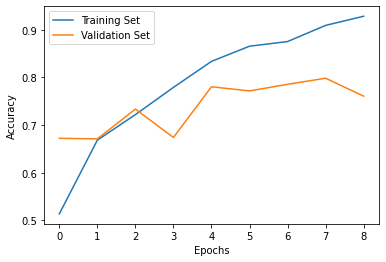

In [24]:
training_accuracy = training_history.history['accuracy']
validation_accuracy = training_history.history['val_accuracy']

plt.figure()
plt.plot(np.arange(early_stopping.stopped_epoch), training_accuracy[0:early_stopping.stopped_epoch], label = 'Training Set')
plt.plot(np.arange(early_stopping.stopped_epoch), validation_accuracy[0:early_stopping.stopped_epoch], label = 'Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [25]:
model.evaluate(testing_set)

80/80 [==============================] - 7s 89ms/step - loss: 0.5841 - accuracy: 0.7983


[0.5840810537338257, 0.7983490824699402]

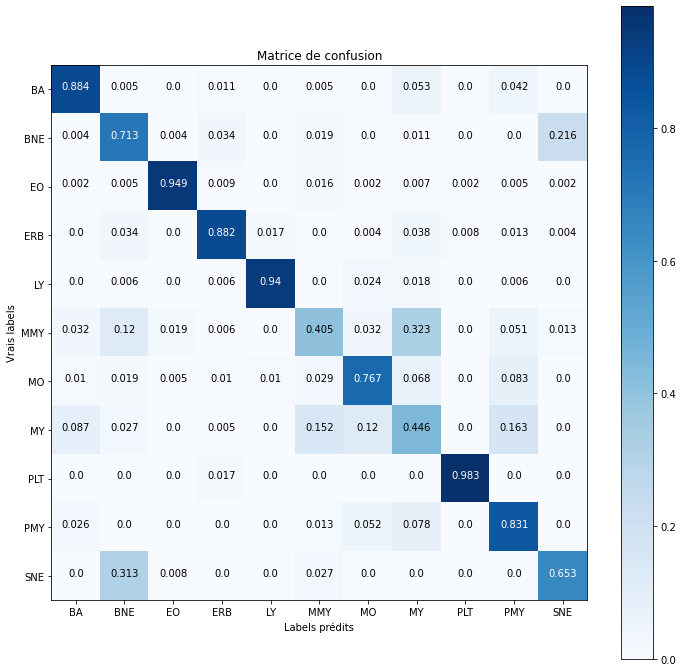

Classification Report 


,precision,recall,f1-score,support
BA,0.860825,0.883598,0.872063,189
BNE,0.610224,0.712687,0.657487,268
EO,0.983213,0.949074,0.965842,432
ERB,0.889362,0.881857,0.885593,237
LY,0.963415,0.940476,0.951807,168
MMY,0.537815,0.405063,0.462094,158
MO,0.810256,0.76699,0.78803,206
MY,0.453039,0.445652,0.449315,184
PLT,0.991667,0.983471,0.987552,363
PMY,0.481203,0.831169,0.609524,77


In [52]:
### 1 -- Rapport de classification :
def print_classification_report(testing_set, labels):

  # Prédiction : utilise le jeu de test (testing_set)
  predictions = model.predict(testing_set)
  y_pred = tf.argmax(predictions, axis = 1)

  # Calcul et affichage de la matrice de confusion
  cnf_matrix = confusion_matrix(testing_set.classes, y_pred, normalize = 'true')
  classes = range(len(labels))
  
  plt.figure(figsize = (12,12))
  plt.imshow(cnf_matrix, interpolation = 'nearest', cmap = 'Blues')
  plt.title("Matrice de confusion")
  plt.colorbar()

  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels)
  plt.yticks(tick_marks, labels)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), 
                                range(cnf_matrix.shape[1])):
    plt.text(j, i, np.around(cnf_matrix[i, j], decimals = 3),
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('Vrais labels')
  plt.xlabel('Labels prédits')
  plt.show()

  # Rapport de classification 
  report = classification_report(testing_set.classes, y_pred, target_names = labels, output_dict = True)

  df_report = pd.DataFrame(index = list(report.keys())[:-3], columns = list(report["BA"].keys()))
  for key in list(report.keys())[:-3]:
    for column in list(report["BA"].keys()):
      df_report.loc[key, column] = report[key][column]
  
  print("Classification Report ")
  return display(df_report)


## Bilan sur les données de test :
print_classification_report(testing_set, label_map)

[ 6  9  7  5  0  4  3  2  1  8 10]


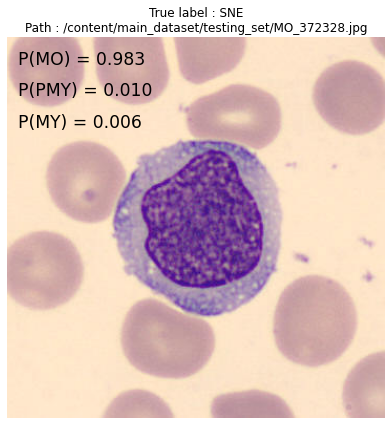

In [42]:
### 4 -- Prédiction sur une image + Grad-CAM associée aux prédictions

def full_prediction(model, img_path, label, size = (img_height, img_width)):

  ## Preprocessing de l'image
  img = get_img_array(img_path, size = size)

  ## Prediction
  probas = model.predict(img)[0]
  sorted_indexes = np.flip(np.argsort(probas))
  print(sorted_indexes)
  sorted_classes = [classes[i] for i in sorted_indexes]
  sorted_probas = [probas[i] for i in sorted_indexes]
  
  ## Plot (3 classes les plus probables)
  fig = plt.figure(figsize = (7,7))

  ax1 = fig.add_subplot(1,1,1)
  ax1.imshow(plt.imread(img_path))
  ax1.text(x = 10, y = 25, s = 'P(%s) = %0.3f'%(sorted_classes[0], sorted_probas[0]), fontsize = 'xx-large')
  ax1.text(x = 10, y = 55, s = 'P(%s) = %0.3f'%(sorted_classes[1], sorted_probas[1]), fontsize = 'xx-large')
  ax1.text(x = 10, y = 85, s = 'P(%s) = %0.3f'%(sorted_classes[2], sorted_probas[2]), fontsize = 'xx-large')
  ax1.set_title('True label : '+label+'\nPath : '+img_path)
  plt.grid(None)
  plt.axis('off')

  return probas, sorted_probas, sorted_classes

probas, sorted_probas, sorted_classes = full_prediction(model, 
                                                        "/content/main_dataset/testing_set/MO_372328.jpg", 
                                                        label = 'SNE', 
                                                        size = (img_height, img_width))

(array([[ 54,  33,  43, ..., 115,  93,  71],
        [ 44,  39,  48, ..., 125, 122,  93],
        [ 42,  41,  50, ..., 123, 134, 116],
        ...,
        [103, 102, 101, ...,  79,  80,  78],
        [102, 101, 100, ...,  73,  74,  74],
        [102, 101, 101, ...,  66,  68,  69]], dtype=uint8),
 <PIL.Image.Image image mode=RGB size=360x363 at 0x7F5B7B2E7410>)

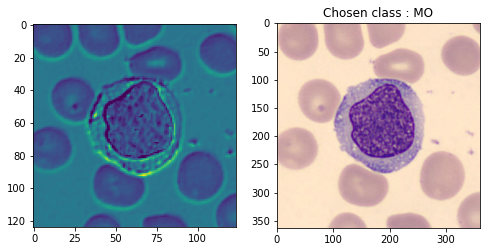

In [49]:
gradcam(model, "/content/main_dataset/testing_set/MO_372328.jpg", img_height, img_width, class_index = None, alpha = 0, plot = True)

In [ ]:
######################################################### Remarque : LeNet à 8 classes ###############################################################

In [21]:
n_classes, df_train, df_test, df_valid = choose_classes(df_train, df_test, df_valid, n_classes = 8)
classes = list(df_train["label"].sort_values().unique())

In [22]:
df_train["label"].value_counts()

NEU    2475
EO     2352
IG     2028
PLT    1743
ERB    1162
MO     1068
LY      946
BA      903
Name: label, dtype: int64

In [23]:
df_valid["label"].value_counts()

EO     336
NEU    324
IG     298
PLT    246
ERB    152
MO     146
BA     126
LY     102
Name: label, dtype: int64

In [25]:
model = Sequential(
    [layers.experimental.preprocessing.Rescaling(1./255, 
                                                 input_shape = (img_height, img_width, 3)),
     layers.Conv2D(filters = 30,
                   kernel_size = (5,5),
                   activation = 'relu',
                   padding = 'valid'),
     layers.MaxPooling2D(pool_size = (2,2)),
     layers.Conv2D(filters = 16,
                   kernel_size = (3,3),
                   activation = 'relu',
                   padding = 'valid'),
     layers.MaxPooling2D(pool_size = (2,2)),
     layers.Dropout(rate = 0.2),
     layers.Flatten(),
     layers.Dense(units = 128, activation = 'relu'),
     layers.Dense(units = n_classes, activation  = 'softmax')
     ])

optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)
model.compile(optimizer = optimizer, 
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

In [26]:
## Training

TON = TerminateOnNaN()
control_lr = ReduceLROnPlateau(monitor = 'val_loss',
                               factor = 0.1, patience = 2, verbose = 1, mode = 'min', min_lr = 1e-6)
  
early_stopping = EarlyStopping(monitor = "val_loss", patience = 3, mode = 'min', restore_best_weights = True)

callbacks_list = [TON, control_lr, early_stopping]

epochs = 30
training_history = model.fit(x = training_set, 
                             epochs = epochs,
                             callbacks = callbacks_list,
                             validation_data = validation_set)

Epoch 1/30
397/397 [==============================] - 42s 104ms/step - loss: 1.1512 - accuracy: 0.6225 - val_loss: 0.5044 - val_accuracy: 0.8503
Epoch 2/30
397/397 [==============================] - 41s 104ms/step - loss: 0.4741 - accuracy: 0.8366 - val_loss: 0.4123 - val_accuracy: 0.8607
Epoch 3/30
397/397 [==============================] - 41s 103ms/step - loss: 0.3296 - accuracy: 0.8863 - val_loss: 0.3291 - val_accuracy: 0.8942
Epoch 4/30
397/397 [==============================] - 41s 104ms/step - loss: 0.2604 - accuracy: 0.9071 - val_loss: 0.3518 - val_accuracy: 0.8763
Epoch 5/30
397/397 [==============================] - 41s 104ms/step - loss: 0.1953 - accuracy: 0.9335 - val_loss: 0.3506 - val_accuracy: 0.8751

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/30
397/397 [==============================] - 42s 105ms/step - loss: 0.1000 - accuracy: 0.9696 - val_loss: 0.2567 - val_accuracy: 0.9289
Epoch 7/30
397/397 [============================

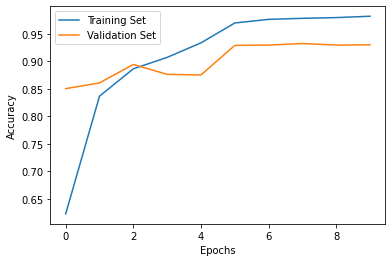

In [27]:
training_accuracy = training_history.history['accuracy']
validation_accuracy = training_history.history['val_accuracy']

plt.figure()
plt.plot(np.arange(early_stopping.stopped_epoch), training_accuracy[0:early_stopping.stopped_epoch], label = 'Training Set')
plt.plot(np.arange(early_stopping.stopped_epoch), validation_accuracy[0:early_stopping.stopped_epoch], label = 'Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
model.evaluate(testing_set)

80/80 [==============================] - 7s 88ms/step - loss: 0.2366 - accuracy: 0.9249


[0.2366374284029007, 0.9249213933944702]

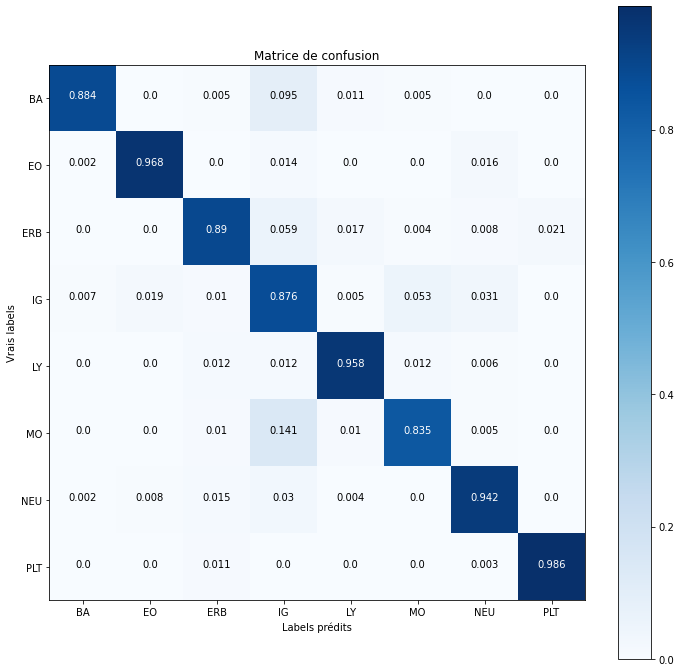

Classification Report 


,precision,recall,f1-score,support
BA,0.97093,0.883598,0.925208,189
EO,0.972093,0.967593,0.969838,432
ERB,0.909483,0.890295,0.899787,237
IG,0.811947,0.875895,0.84271,419
LY,0.930636,0.958333,0.944282,168
MO,0.868687,0.834951,0.851485,206
NEU,0.95229,0.941509,0.946869,530
PLT,0.986226,0.986226,0.986226,363


In [28]:
### 1 -- Rapport de classification :
def print_classification_report(testing_set, labels):

  # Prédiction : utilise le jeu de test (testing_set)
  predictions = model.predict(testing_set)
  y_pred = tf.argmax(predictions, axis = 1)

  # Calcul et affichage de la matrice de confusion
  cnf_matrix = confusion_matrix(testing_set.classes, y_pred, normalize = 'true')
  classes = range(len(labels))
  
  plt.figure(figsize = (12,12))
  plt.imshow(cnf_matrix, interpolation = 'nearest', cmap = 'Blues')
  plt.title("Matrice de confusion")
  plt.colorbar()

  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels)
  plt.yticks(tick_marks, labels)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), 
                                range(cnf_matrix.shape[1])):
    plt.text(j, i, np.around(cnf_matrix[i, j], decimals = 3),
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('Vrais labels')
  plt.xlabel('Labels prédits')
  plt.show()

  # Rapport de classification 
  report = classification_report(testing_set.classes, y_pred, target_names = labels, output_dict = True)

  df_report = pd.DataFrame(index = list(report.keys())[:-3], columns = list(report["BA"].keys()))
  for key in list(report.keys())[:-3]:
    for column in list(report["BA"].keys()):
      df_report.loc[key, column] = report[key][column]
  
  print("Classification Report ")
  return display(df_report)


## Bilan sur les données de test :
print_classification_report(testing_set, label_map)